# Ground Truth Comparison

This notebook shows how [SpikeInterface](https://github.com/SpikeInterface) is used to perform a ground truth comparisong for multiple spike sorters.

Note the notebook assumes the recording is alreay sorted, the neccessary data can be downloaded here:

[https://drive.google.com/drive/folders/1ZwLDz0mmTyUYTbAJ2TX53XRa0l0zA-K-?usp=drive_open](https://drive.google.com/drive/folders/1ZwLDz0mmTyUYTbAJ2TX53XRa0l0zA-K-?usp=drive_open)

The results were generated with spikeinterface version 0.9.1.

In [1]:

import os
import sys
import matplotlib.pyplot as plt
import spikeextractors as se
import spiketoolkit as st
import pandas as pd
import spikewidgets as sw
import spikesorters as ss
import spikecomparison as sc
import numpy as np
import scipy
import seaborn as sns
from pathlib import Path
import pickle
from spikecomparison import GroundTruthStudy

import networkx as nx

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
# set the data path
p = Path('/data/MEA/spikeinterface/MEArec/')
study_folder = p / 'study_mearec_SqMEA1015um/'

mearec_filename = p / 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
gt_sorting0 = se.MEArecSortingExtractor(mearec_filename)

# compute GT unit SNR
snr_file = study_folder / 'snr.pickle'
if os.path.isfile(snr_file):
    snr = pd.read_pickle(snr_file)
else:
    print('computing snr')
    rec0 = se.MEArecRecordingExtractor(mearec_filename)
    snr = st.validation.compute_snrs(gt_sorting0, rec0)
    snr = pd.Series(snr, index=gt_sorting0.get_unit_ids())
    snr.name = 'snr'
    snr_file = study_folder / 'snr.pickle'
    snr.to_pickle(snr_file)

In [3]:
# run comparison and get all relevant data
study = GroundTruthStudy(study_folder)
sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
               'spykingcircus', 'tridesclous', 'mountainsort4']
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
               'SpykingCircus', 'Tridesclous', 'Mountainsort4']
study.run_comparisons(exhaustive_gt=True, match_score=0.1, overmerged_score=0.2)

comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

# add snr to the by-unit table
dataframes['perf_by_units']['snr'] = None
for i,s in enumerate(snr):
    dataframes['perf_by_units']['snr'].loc[dataframes['perf_by_units'].gt_unit_id==i] = s

dataframes['perf_by_units'][:5]

/data/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,rec_name,sorter_name,gt_unit_id,accuracy,recall,precision,false_discovery_rate,miss_rate,snr
0,rec0,kilosort2,0,0,0,0,0,0,4.54862
1,rec0,kilosort2,1,0.989717,0.989717,1,0,0.0102828,13.6905
2,rec0,kilosort2,2,0.997561,0.997561,1,0,0.00243902,6.62917
3,rec0,kilosort2,3,1,1,1,0,0,10.8414
4,rec0,kilosort2,4,1,1,1,0,0,19.3523


[]

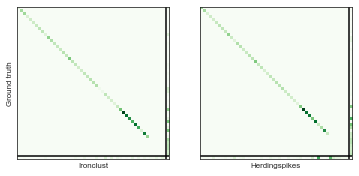

In [4]:
# confusion matrices

plt.figure(figsize=(6,3))
comp = comparisons['rec0','ironclust']
ax=plt.subplot(121)
sw.plot_confusion_matrix(comp, ax=ax, count_text=False, unit_ticks=False)
ax.set_xticks(())
ax.set_yticks(())
ax.set_xlabel('Ironclust',rotation=0, fontsize=8)
ax.set_ylabel('Ground truth',rotation=90, fontsize=8)
comp = comparisons['rec0','herdingspikes']
ax=plt.subplot(122)
sw.plot_confusion_matrix(comp, ax=ax, count_text=False, unit_ticks=False)
ax.set_xlabel('Herdingspikes',rotation=0, fontsize=8)
ax.set_ylabel('',rotation=0, fontsize=8)
ax.set_xticks(())
ax.set_yticks(())

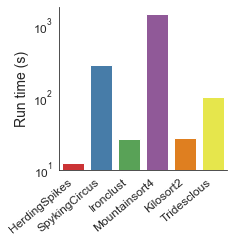

In [5]:


run_times = dataframes['run_times']
perf_units = dataframes['perf_by_units']
count_units = dataframes['count_units']

exclude_sorters = []

if len(exclude_sorters) > 0:
    for name in exclude_sorters:
        run_times = run_times[run_times['sorter_name'] != name]
        perf_units = perf_units[perf_units['sorter_name'] != name]
        perf_avg = perf_avg[perf_avg['sorter_name'] != name]
        count_units = count_units[count_units['sorter_name'] != name]

# Use proper names for labels
sorter_order = run_times['sorter_name']
sorters = run_times['sorter_name'].copy()
for i in range(len(sorters)):
    sorters.loc[sorters==sorter_list[i]] = sorter_names[i]
    
fig = plt.figure(figsize=(3,3))
sns.set_palette(sns.color_palette("Set1"))#

ax = plt.subplot(111)
p = sns.barplot(data=run_times, x='sorter_name', y='run_time', ax=ax, order=sorter_order)
# p = sns.catplot(data=dataframes['run_times'], x='sorter_name', y='run_time', ax=ax, order=sorters, kind='bar')
# p.fig.get_axes()[0].set_yscale('log')
p.set_yscale('log')
plt.ylabel('Run time (s)');
plt.xlabel(None);
# p.set_xticklabels(sorters, rotation=90, ha='center')
ax.set_xticklabels(sorters, rotation=40, ha='right')

clear_axes(ax)


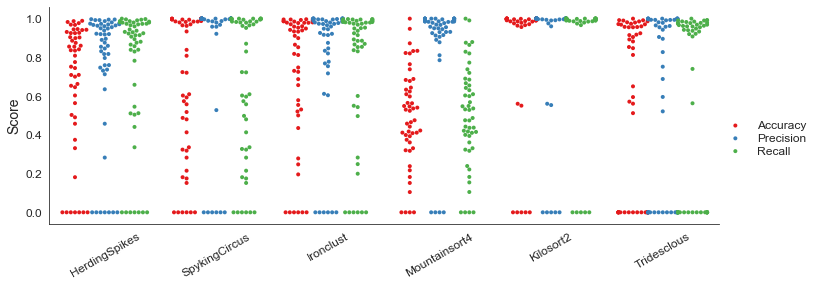

In [11]:
plt.figure(figsize=(12,4))
fig.tight_layout()

ax = plt.subplot(111)
sns.set_palette(sns.color_palette("Set1"))#
df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('accuracy','precision', 'recall'))
# df.assign(Generation=df.metric.map({'metric':'Metric','accuracy': 'Accuracy', 'precision': 'Precision', 'recall': 'Recall'}))
p = sns.catplot(data=df, x='sorter_name', y='score', hue='metric', kind='swarm', dodge=True, ax=ax, 
                order=sorter_order, legend_out=True, s=4)
plt.close(p.fig)
ax.legend(['Accuracy', 'Precision', 'Recall'], labelspacing=0.2,
          bbox_to_anchor=(1, 0.5), loc=2, borderaxespad=0., frameon=False)
ax.set_xticklabels(sorters, rotation=30, ha='center')
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)


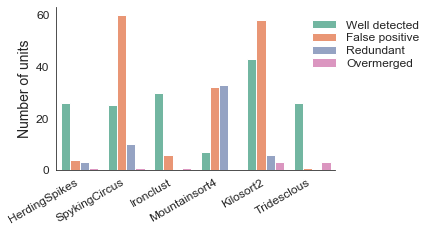

In [7]:
plt.figure(figsize=(5,3))
ax = plt.subplot(111)
sns.set_palette(sns.color_palette("Set2"))#
df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
# p = sns.barplot(data=df, x='sorter_name', y='score', hue='metric', ax=ax, 
#                 order=sorter_order)
p = sns.catplot(x='sorter_name', y='score', hue='metric', data=df,
                height=6, kind="bar", ax=ax, order=sorter_order)
plt.close(p.fig)
ax.set_xticklabels(sorters, rotation=30, ha='right')
# p.legend(loc='right', bbox_to_anchor=(1.8, 0.5), ncol=1, frameon=False)
# ax.legend(["Detected\nunits", "Redundant\nunits", "False positive\nunits"],
#           bbox_to_anchor=(0.8, 0.45), loc=2, borderaxespad=0., frameon=True)
ax.legend(bbox_to_anchor=(0.9, 0.95), borderaxespad=0., frameon=False, labelspacing=0.2)
for t, l in zip(ax.legend_.texts,("Well detected", "False positive", "Redundant", "Overmerged")):
    t.set_text(l)
ax.legend_.set_title(None)
ax.set_xlabel(None);
ax.set_ylabel('Number of units');
clear_axes(ax)



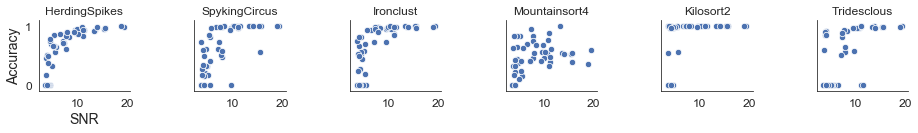

In [14]:
sns.set_palette(sns.color_palette("deep"))#
height = 2
aspect = 1.1
g = sns.relplot(data=dataframes['perf_by_units'], x='snr', y='accuracy', col='sorter_name', 
                height=height, aspect=aspect, col_wrap=6, col_order=sorter_order, s=40)
for i,ax in enumerate(g.axes):
    ax.set_title(sorters[i])
    ax.set_xlabel('')
g.axes[0].set_xlabel('SNR');
g.axes[0].set_ylabel('Accuracy');
